# mnist-visual-fields

Importing external libraries and modules

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Tuple, List, Dict, Callable
from modules.dataset.dataset import Dataset, Data
import modules.utils.utils as ut
import modules.metrics.metrics as mt
from modules.plotting_network.plotting_network import NeuralNetworkPlotter

Check if tensorflow is using GPU

In [3]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


### Importing MNIST dataset and normalizing input

In [4]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
x_train, x_test = ut.normalize_dataset(x_train, x_test)
train = Data(x_train, y_train)
test = Data(x_test, y_test)

### Generating dataset

In [5]:
dataset = Dataset(train, test)
dataset.build_vf_dataset(proportion_cs=0.5, 
                         proportion_left=0.5, 
                         full_attention_value=1, 
                         reduced_attention_value=0.5, 
                         ss_attention_value=0.5)

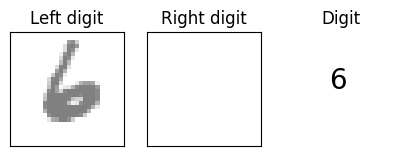

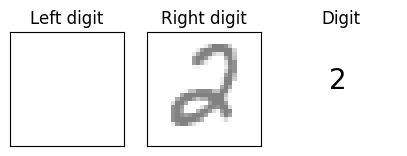

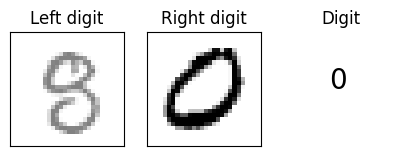

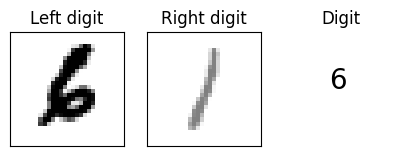

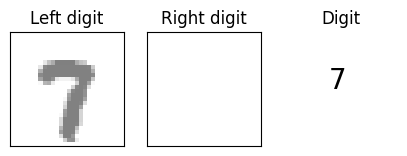

In [6]:
ut.show_dataset(dataset.train_vf.x_left, dataset.train_vf.x_right, y_data=dataset.train_vf.y, num_images=5, print_index=False)

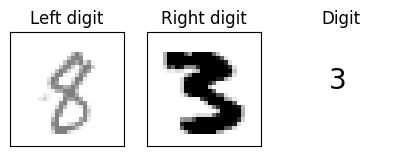

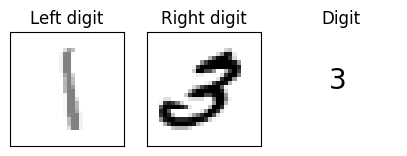

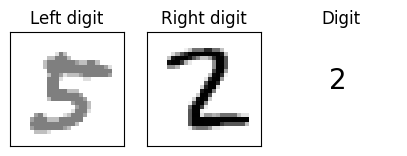

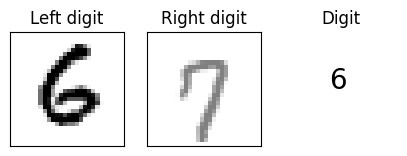

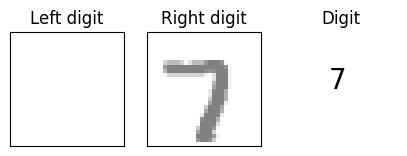

In [7]:
ut.show_dataset(dataset.test_vf.x_left, dataset.test_vf.x_right, y_data=dataset.test_vf.y, num_images=5, print_index=False)

### Model definitions

In [8]:
def model_t1_srf(n: int, n_neurons: int = 32) -> tf.keras.Model:
    input_layer = tf.keras.layers.Input(shape=[28,28], name="input")
    flatten_input = tf.keras.layers.Flatten()(input_layer)

    dense = flatten_input
    for i in range(n):
        dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"srf_dense{i+1}")(dense)
    
    output = tf.keras.layers.Dense(10, activation="softmax", name="output")(dense)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output])

    return model

def model_t1_conv_srf(n: int, n_neurons: int = 32, n_filters: int = 1) -> tf.keras.Model:
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1), name="input")
    conv = tf.keras.layers.Conv2D(n_filters, 3, activation="relu")(input_layer)
    flatten = tf.keras.layers.Flatten()(conv)

    dense = flatten
    for i in range(n):
        dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"srf_dense{i+1}")(dense)
    
    output = tf.keras.layers.Dense(10, activation="softmax", name="output")(dense)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output])

    return model

def model_t1_drf(n: int, n_neurons: int = 32) -> tf.keras.Model:
    n_before_concatenation = n // 2
    n_after_concatenation = n - n_before_concatenation

    left_input = tf.keras.Input(shape=(28, 28), name="left_input")
    right_input = tf.keras.Input(shape=(28, 28), name="right_input")
    left_flatten = tf.keras.layers.Flatten(name="left_flatten")(left_input)
    right_flatten = tf.keras.layers.Flatten(name="right_flatten")(right_input)

    # Before concatenation
    left_dense = left_flatten
    right_dense = right_flatten
    for i in range(n_before_concatenation):
        left_dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"left_dense{i+1}")(left_dense)
        right_dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"right_dense{i+1}")(right_dense)
    
    # Concatenation
    concatenate = tf.keras.layers.Concatenate(name="concatenate")([left_dense, right_dense])

    # After concatenation
    dense = concatenate
    for i in range(n_after_concatenation):
        dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"drf_dense{i+1}")(dense)
    
    output = tf.keras.layers.Dense(10, activation="softmax", name="output")(dense)
    model = tf.keras.Model(inputs=[left_input, right_input], outputs=[output])

    return model

def model_conv_drf_t1(n: int, n_neurons: int = 32, n_filters: int = 1) -> tf.keras.Model:
    n_before_concatenation = n // 2
    n_after_concatenation = n - n_before_concatenation

    left_input = tf.keras.Input(shape=(28, 28, 1), name="left_input") # third dimension is the number of channels
    right_input = tf.keras.Input(shape=(28, 28, 1), name="right_input")

    # Convolutional layers
    left_conv = tf.keras.layers.Conv2D(
        n_filters, kernel_size=(3, 3), strides=1, activation="relu", padding="same", name="left_conv1")(left_input)
    right_conv = tf.keras.layers.Conv2D(
        n_filters, kernel_size=(3, 3), strides=1, activation="relu", padding="same", name="right_conv1")(right_input)

    # Flatten layers after convolution
    left_flatten = tf.keras.layers.Flatten(name="left_flatten")(left_conv)
    right_flatten = tf.keras.layers.Flatten(name="right_flatten")(right_conv)

    # Before concatenation
    left_dense = left_flatten
    right_dense = right_flatten
    for i in range(n_before_concatenation):
        left_dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"left_dense{i+1}")(left_dense)
        right_dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"right_dense{i+1}")(right_dense)
    
    # Concatenation
    concatenate = tf.keras.layers.Concatenate(name="concatenate")([left_dense, right_dense])

    # After concatenation
    dense = concatenate
    for i in range(n_after_concatenation):
        dense = tf.keras.layers.Dense(n_neurons, activation="relu", name=f"drf_dense{i+1}")(dense)
    
    output = tf.keras.layers.Dense(10, activation="softmax", name="output")(dense)
    model = tf.keras.Model(inputs=[left_input, right_input], outputs=[output])

    return model

### Training model

Hyperparameters

In [9]:
epochs = 10
batch_size = 256

Training 

In [ ]:
model = model_conv_drf_t1(n=5, n_neurons=32, n_filters=32)
training_generator = ut.data_generator_dvf(
    dataset.train_vf.x_left, dataset.train_vf.x_right, dataset.train_vf.y, batch_size
)
testing_generator = ut.data_generator_dvf(
    dataset.test_vf.x_left, dataset.test_vf.x_right, dataset.test_vf.y, batch_size
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history_model = model.fit(
    training_generator,
    steps_per_epoch=len(dataset.train_vf.y) // batch_size,
    epochs=epochs,
    validation_data=testing_generator,
    validation_steps=len(dataset.test_vf.y) // batch_size,
)

model.evaluate(testing_generator, steps=len(dataset.train.y) // batch_size)
ut.plot_loss_accuracy(history_model)

Saving model

In [ ]:
model_name = "model_t1_drf_conv"
model_path = f'models/{model_name}' # _{epochs}_{batch_size}
os.makedirs(model_path, exist_ok=True)
model.save(model_path + '/model_srf.keras')

### Loading a model

In [6]:
model = tf.keras.models.load_model('models/model.keras')

### Visualizing neural network

Chosing input for visualization

Left visual field

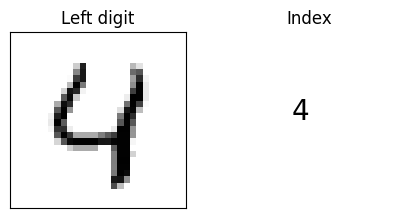

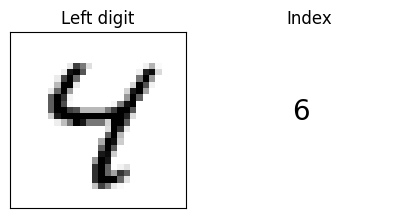

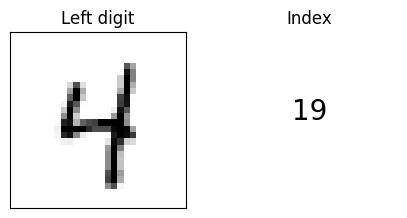

In [7]:
ut.display_n_digits(x_test, y_test, digit=4, n=3)

Right visual field

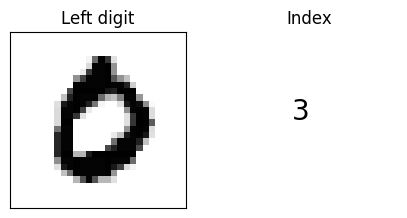

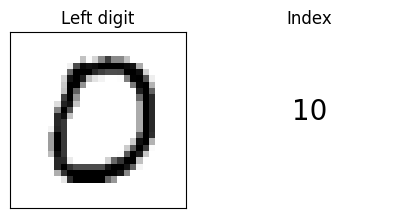

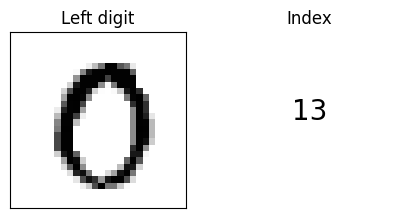

In [11]:
ut.display_n_digits(x_test, y_test, digit=0, n=3)

## Plotting neural network

Creating new plotter

In [ ]:
plotter = NeuralNetworkPlotter(model)

Generating and training attribute lenses

In [ ]:
plotter.generate_attribute_lenses()
plotter.train_attribute_lenses(dataset=dataset, epochs=epochs, batch_size=batch_size)

Plotting

In [ ]:
plotter.plot(x_test[11], x_test[10] * 0.5)

Saving plotters

In [ ]:
plotter_path = f'models/'
plotter_filename = f'plotter.plt'
plotter_filepath = plotter_path + plotter_filename
os.makedirs(plotter_path, exist_ok=True)

ut.save_obj(plotter_filepath, plotter)

Loading plotter from a file

In [ ]:
plotter_loaded = ut.load_obj('models/plotter.plt')

### Metrics for Neural Network

### Cosine similarity matrix (CSM)

Computing CSM

In [119]:
prototypes = mt.generate_prototypes_mp(model=model, x_data=dataset.test.x, y_data=dataset.test.y, n=2)
cs_matrices = mt.compute_cosine_similarity_matrix(model=model, prototypes=prototypes)

Save CSM

In [156]:
cs_matrices_path = f'results/cosine_similarity/'
cs_matrices_filename = f'{model_name}_predict_n200.csm'
cs_matrices_filepath = cs_matrices_path + cs_matrices_filename
os.makedirs(cs_matrices_path, exist_ok=True)

ut.save_obj(cs_matrices_filepath, cs_matrices)

Load CSM

In [106]:
csm_loaded = ut.load_obj("results/cosine_similarity/t1_drf_95/list_t1_drf_95_20.csm")[0]

Visualize CSM

In [ ]:
for layer_name in csm_loaded.keys():
    mt.plot_csm(cs_matrices=cs_matrices, layer_name=layer_name, title=layer_name)

Plot CSM interactively

In [ ]:
mt.plot_csm_interactively(cs_matrices=cs_matrices)

### Compute orthogonality

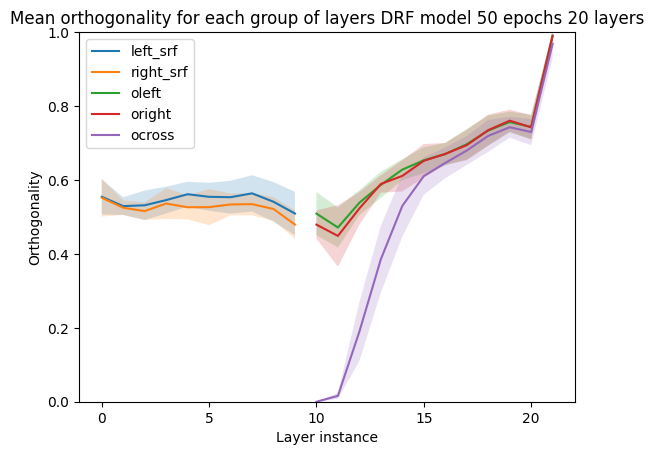

In [91]:
orthogonalities = mt.compute_orthogonality_grouping_layers(cs_matrices=cs_matrices, separate_drf=True)
mean, deviations = mt.compute_mean_and_deviation(orthogonalities)
mt.plot_orthogonality(mean, deviations=deviations, label='Mean orthogonality for each group of layers DRF model 50 epochs 20 layers')

### Pipeline to train and plot metrics of multiple models

In [11]:
def train_n_models(
        model_definition: Callable[[any], tf.keras.Model], 
        num_models: int, x_train: List[np.array], 
        y_train: np.array, 
        epochs: int = 50, 
        batch_size: int = 256, 
        val_split: float = 0,
        callbacks: List[tf.keras.callbacks.Callback] = [],
        model_args: List[any] = [],
        custom_dir: str = "",
        model_name: str = "",
        save: bool = True
    ) -> List[tf.keras.Model]:

    models = []

    if val_split > 0:
        x_train, x_val = ut.split_array(x_train, val_split)
        y_train, y_val = ut.split_array(y_train, val_split)

    if len(x_train) == 1: # If single visual field model
        data_generator = ut.data_generator_svf
    else: # If double visual field model
        data_generator = ut.data_generator_dvf

    for _ in range(num_models):
        train_generator = data_generator(*x_train, y_train, batch_size)
        if val_split > 0:
            val_generator = data_generator(*x_val, y_val, batch_size)
        
        model = model_definition(*model_args)
        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"],
        )

        model.fit(
            train_generator,
            steps_per_epoch=len(y_train) // batch_size,
            epochs=epochs,
            validation_data=val_generator if val_split > 0 else None,
            validation_steps=(len(y_val) // batch_size) if val_split > 0 else None,
            callbacks=callbacks
        )

        if len(callbacks) > 0:
            print(f"Model stopped training at epoch {callbacks[0].previous_epochs[-1]}")

        models.append(model)

    if len(callbacks) > 0:
        callbacks[0].epochs.append(callbacks[0].previous_epochs.copy())
        callbacks[0].previous_epochs = []
    
    if save:
        custom_dir = f"{custom_dir}/" if custom_dir != "" else ""
        model_name = f"{model_definition.__name__}_{ut.get_current_time_string()}" if model_name == "" else model_name
        ut.save_obj(f"models/{custom_dir}list_{model_name}", models)
    
    return models

def compute_csm_models(
        models: List[tf.keras.Model], 
        x_test: np.array, 
        y_test: np.array, 
        num_protoype: int,
        custom_dir: str = "",
        model_name: str = "",
        use_mp_protoype: bool = True,
        save: bool = True
    ) -> List[Dict[str, np.array]]:
    
    csm_list = []
    for model in models:
        if use_mp_protoype:
            prototypes = mt.generate_prototypes_mp(model=model, x_data=x_test, y_data=y_test, n=num_protoype)
        else:
            prototypes = mt.generate_prototypes(model=model, x_data=x_test, y_data=y_test, n=num_protoype)
        try:
            cs_matrices = mt.compute_cosine_similarity_matrix(model=model, prototypes=prototypes)
            csm_list.append(cs_matrices)
        except ValueError as ve:
            print(f"Error caused {model.name} to be skipped: {ve}")
            continue # Skip model if it has an error
    if save:
        custom_dir = f"{custom_dir}/" if custom_dir != "" else ""
        model_name = f"model_csm_{ut.get_current_time_string()}" if model_name == "" else model_name
        ut.save_obj(f"results/cosine_similarity/{custom_dir}list_{model_name}.csm", csm_list)
    
    return csm_list

def compute_orthogonality_models(
        csm_list: List[Dict[str, np.array]], 
        is_srf_model: bool,
        custom_dir: str = "",
        model_name: str = "",
        separate_drf: bool = True,
        save: bool = True
    ) -> List[Dict[str, np.array]]:

    orthogonalities_list = []
    for csm in csm_list:
        orthogonalities = mt.compute_orthogonality_grouping_layers(csm, is_srf_model=is_srf_model, separate_drf=separate_drf)
        orthogonalities_list.append(orthogonalities)
    if save:
        custom_dir = f"{custom_dir}/" if custom_dir != "" else ""
        model_name = f"model_orth_{ut.get_current_time_string()}" if model_name == "" else model_name
        ut.save_obj(f"results/orthogonalities/{custom_dir}list_{model_name}.orth", orthogonalities_list)

    return orthogonalities_list

def run_orthogonality_computation(
        model_definition: Callable[[any], tf.keras.Model], 
        num_models: int, 
        x_train: List[np.array], 
        y_train: np.array, 
        x_test: np.array, 
        y_test: np.array, 
        num_protoype: int,
        epochs: int = 50,
        batch_size: int = 256,
        val_split: float = 0,
        callbacks: List[tf.keras.callbacks.Callback] = [],
        model_args: List[any] = [],
        custom_dir: str = "",
        model_name: str = "",
        use_mp_protoype: bool = True,
        separate_drf: bool = True,
        save: bool = True
    ) -> Tuple[Dict[str, np.array], Dict[str, np.array]]:

    model_name = f"{model_definition.__name__}_{ut.get_current_time_string()}" if model_name == "" else model_name

    models = train_n_models(
        model_definition=model_definition, 
        num_models=num_models, 
        x_train=x_train, 
        y_train=y_train,
        epochs=epochs,
        batch_size=batch_size,
        val_split=val_split, 
        callbacks=callbacks,
        model_args=model_args,
        custom_dir=custom_dir,
        model_name=model_name,
        save=save
    )
        
    csm_list = compute_csm_models(
        models=models, 
        x_test=x_test, 
        y_test=y_test, 
        num_protoype=num_protoype,
        custom_dir=custom_dir,
        model_name=model_name,
        use_mp_protoype=use_mp_protoype,
        save=save
    )

    orthogonalities_list = compute_orthogonality_models(
        csm_list=csm_list,
        custom_dir=custom_dir,
        model_name=model_name, 
        is_srf_model=len(x_train) == 1,
        separate_drf=separate_drf,
        save=save
    )

    mean, deviations = mt.compute_mean_and_deviation(orthogonalities_list)
    return (mean, deviations)

Running pipeline to compute orthogonalities

In [ ]:
model_orth_drf = {}
max_epochs = 500
callbacks = [mt.EpochStopping(max_epochs=max_epochs, acc_diff_threshold=0.0005, n_accs=5, max_train_acc=0.95)] # 0.99
for num_layer in [5, 10, 15, 20, 25, 30]:
    model_orth_drf[f"{num_layer}"] = run_orthogonality_computation(
        model_definition=model_t1_drf,
        num_models=10,
        x_train=[dataset.train_vf.x_left, dataset.train_vf.x_right],
        y_train=dataset.train.y,
        x_test=dataset.test.x,
        y_test=dataset.test.y,
        epochs=max_epochs,
        batch_size=256,
        num_protoype=100,
        use_mp_protoype=False,
        val_split=0,
        callbacks=callbacks,
        model_args=[num_layer],
        custom_dir="t1_drf_95_100",
        model_name=f"t1_drf_95_100_{num_layer}",
        save=True
    )

Plotting orthogonalities

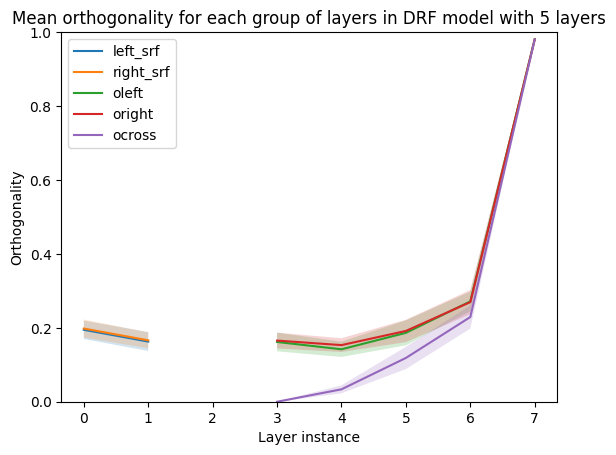

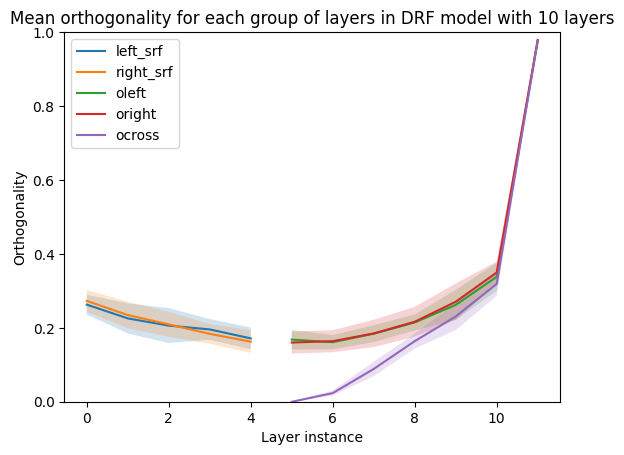

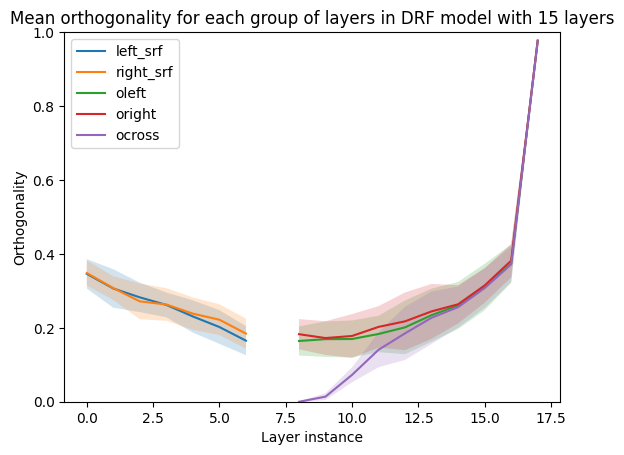

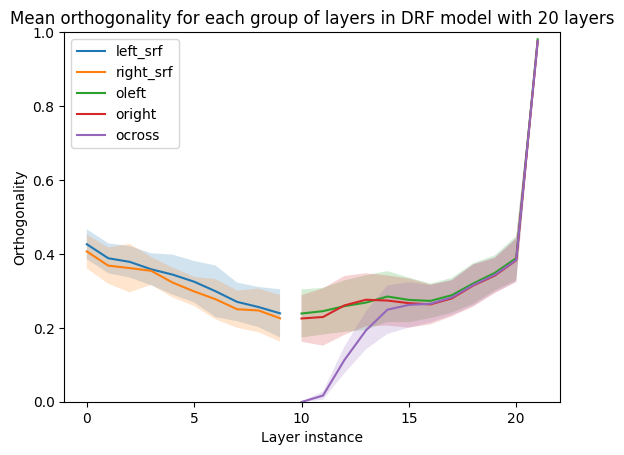

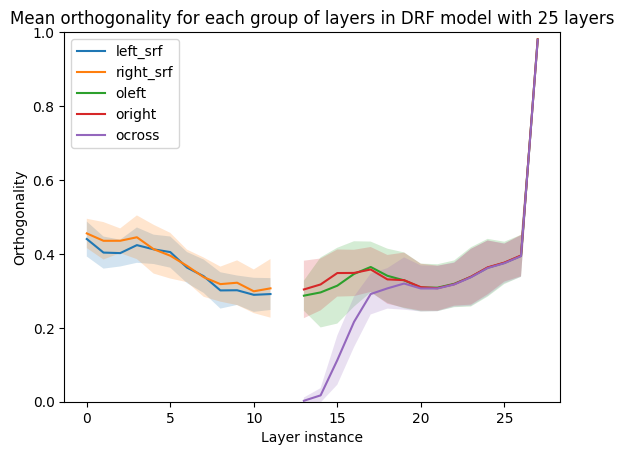

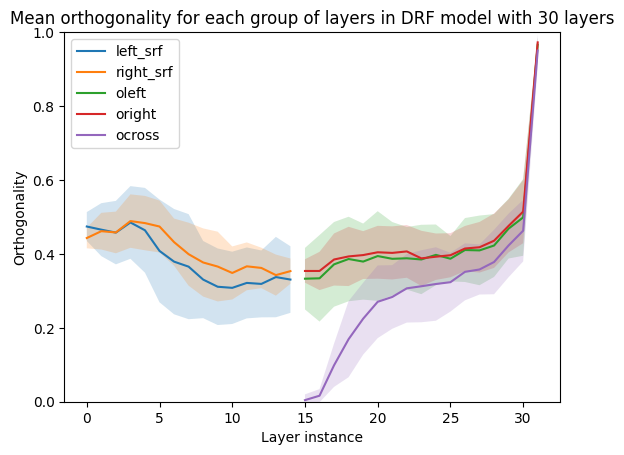

In [29]:
model_orth = model_orth_drf
for key in model_orth:
    mt.plot_orthogonality(model_orth[key][0], deviations=model_orth[key][1], label=f'Mean orthogonality for each group of layers in DRF model with {key} layers')

Evaluating models

In [ ]:
models_dict = {} # models should be organized in dictionary by model name
mt.evaluate_models(models=models_dict, dataset=dataset)